In [1]:
import platform, os, sys, datetime, re, itertools, warnings, pickle, bz2
from os.path import join
import cv2
from scipy.signal import find_peaks
from collections import defaultdict
import random
import math
import itertools as itt
import pandas as pd
from glob import glob
import itertools as itt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.lines import Line2D
import scikit_posthocs as ph
import re
from statsmodels.stats.power import TTestIndPower
import seaborn as sns
from matplotlib import cm
from matplotlib import colors
from importlib import reload
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from io import StringIO
from tqdm import tqdm


sys.path.append('trilab-tracker-0.1.2')
import trilabtracker
reload(trilabtracker)
import trilabtracker.utils as utils

# orientations in degrees, distances in cm.

### Parse Trial Info

In [2]:
# deal with naming inconsistencies
df = pd.read_csv('naming_atlas.csv', usecols = ['folder-name', 'video-name'])
naming_atlas = dict(zip(df['video-name'],df['folder-name']))

# get trial info
for video_name in naming_atlas:
    if naming_atlas[video_name] == 'None': naming_atlas[video_name] = video_name

# tank diameters
tank_diameter_vs_age = { 7:9.6, 14:10.4, 21:12.8, 28:17.7, 42:24.2,
                         56:33.8, 70:33.8, 84:33.8 }

ages = [7, 28, 42, 70]

def parse(trial_file):
    trial_dir    = os.path.dirname(trial_file)
    trial_name   = os.path.basename(trial_dir)
    correct_name = str.lower(naming_atlas[trial_name])
    pop          = correct_name.split('_')[0]
    age          = int(correct_name.split('_')[2][:-3])
    n_ind        = int(correct_name.split('_')[4][1:2]) 
    R_cm         = tank_diameter_vs_age[age]/2
    trial        = { k:v for k,v in locals().items() if k in ['trial_dir','trial_name','folder','correct_name',
                                                              'pop','age','n_ind','R_cm']}
    return(trial)

### Get Kinematics

In [3]:
def compute_kinematics(trial,wall_distance=False):
    center      = np.array([trial['tank']['xc'],trial['tank']['yc']])
    px2cm       = trial['R_cm']/trial['tank']['R']
    n           = trial['n_ind']
    pos         = trial['data'][:,:n,:3].copy() # discard extra objects
    pos[:,:,:2] = (pos[:,:,:2]-center[None,None,:])*px2cm # convert to centimeters
    pos[:,:,1]  = -pos[:,:,1] # flip y axis
    for j in range(n): # unwrap orientations
        I          = ~np.isnan(pos[:,j,2])
        pos[I,j,2] = np.unwrap(pos[I,j,2])
    time        = trial['frame_list']/trial['fps']
    vel         = np.gradient(pos,time,axis=0)
    acc         = np.gradient(vel,time,axis=0)
    v           = np.hypot(vel[:,:,0],vel[:,:,1])
    
    d_wall      = trial['R_cm'] - np.hypot(pos[:,:,0],pos[:,:,1])
    trial.update({ k:v for k,v in locals().items() if k in 
                   ['time', 'pos', 'vel', 'acc', 'd_wall', 'v'] })
    return trial

# get difference in orientation between 2 fish
def orientation_compare (angle1, angle2):
    do = angle1 - angle2
    do = abs(do - 360 * np.rint(do/360))
    return(do)

### Load Trial Info + Kinematics

In [4]:
corrected = pd.read_excel('tracking_progress.xlsx', usecols = ['video','qual_check'])
corrected = dict(zip(corrected.video,corrected.qual_check))

all_files = glob('tracking-data/*/trial.pik')

def get_info (pop):
    # ultimately create a folder with only corrected usable tracks and remove the following line
    #      !!!!!
    trial_files = [f for f in all_files if corrected[os.path.basename(os.path.dirname(f))] == 'yes']
    trials = [parse(f) for f in trial_files]
    trials_of_pop = [f for f in trials if pop in f['pop'] and f['n_ind'] == 5] #trials of population with n = 5
    
    for trial in trials_of_pop:
        trial.update(utils.load_trial(os.path.join(trial['trial_dir'],'trial.pik'), load_fixes = True))
        trial = compute_kinematics(trial)
        globals().update(trial)
    
    return(trials_of_pop)

### Get Distance and Orientation Data for Real Trials

In [ ]:
def real_data (sf_or_pa):

    # get info for trials of population
    trials_of_pop = get_info(sf_or_pa)
    
    # this function outputs the following dictionaries. see the comments below to see the contents of each dictionary.
    
    nnd_o = {} # dictionary with age as key and nearest neighbor pair orientations as items
    nnd_o_medians = {} # dictionary with age as key and median nearest neighbor difference in orientation for each trial  
    iids_medians = {} #dictionary with age as key and median interinvidual distance of each trial as items
    nnds = {} #dictionary with age as key and median nearest neighbor distance per individual as items
    nnds_medians = {} #dictionary with age as key and median nearest neighbor distance per trial as items
    byage = {} #dictionary with age as key and trials of that age as items
    trials = {} #keep track of trial names for later
    iids_all = {} # all iids by age
    ii_orientations = {} # all pair orientations
    nn_orientations = {} # all nearest neighbor orientations
    
    #sort trials by age
    for trial in trials_of_pop:
        age = trial['age']
        if age not in byage: byage[age] = []
        byage[age].append(trial)

    for a in ages: 
        print(f'  {a}dpf')
        if a not in nnd_o: 
            nnd_o[a] = []
            nnds[a] = []
            iids_medians[a] = []
            nnd_o_medians[a] = []
            nnds_medians[a] = []
            trials[a] = []
            iids_all[a] = []
            ii_orientations[a] = []
            nn_orientations[a] = []

        for grp in tqdm(byage[a]): #for each trial
            iids = {} # dictionary for iids between focal fish and all other fish in the trial
            nnds_all = [] # nearest neighbor distances per frame for every fish in the trial
            nnd_oes = [] #nearest neighbor orientations per frame for every fish in the trial
            
            for n in np.arange(0,5): # each will be treated as 'focal fish'
                focal_fish = grp['pos'][:, n, :2] #position data for focal fish
                iids[n] = []
                
                trials[a].append(grp['trial_name'])
                
                for x in np.arange(0,5): # focal fish will be compared to all other fish in the trial
                    fish2 = grp['pos'][:, x, :2] #position data for other fish
                    d = np.hypot(focal_fish[:,0] - fish2[:,0], focal_fish[:,1] - fish2[:,1]) #distance between fish
                    d[d==0.000] = [9999] # if comparing fish to itself, make distance huge
                    iids[n].append(d)
                        
                nnd_is = np.argmin(iids[n], axis = 0) #indeces of nearest neighbor fish relative to focal fish
                nnds_all.append(np.min(iids[n], axis = 0)) #append all nearest neighbor distances for focal fish to list
                nnds[a].append(np.min(iids[n], axis = 0)) #find nearest neighbor distances for focal fish
                           
                orientations = [] #list containing orientation differences between focal fish and nearest neighbor
                for frame, nn in enumerate(nnd_is):
                    angle1 = grp['pos'][frame, n, 2] * 180/np.pi #focal fish orientation from tracker output converted to degrees        
                    angle2 = grp['pos'][frame, nn, 2] * 180/np.pi #nearest neighbor orientation from tracker output converted to degrees
    
                    orientations.append(orientation_compare(angle1,angle2)) #run orientation_compare function on each pair of angles
                    nn_orientations[a].append(orientations)
                nnd_oes.append(orientations) #append all NN orientations to list for later           
            
            # find interindividual distances and pair angles between all pairs of fish in trial
            trial_iids = []
            for f1, f2 in list(itt.combinations(np.arange(0,5),2)): 
                trial_iids.append(iids[f1][f2])
                iids_all[a].append(iids[f1][f2])
                angle1 = grp['pos'][:, f1, 2] * 180/np.pi
                angle2 = grp['pos'][:, f2, 2] * 180/np.pi
                ii_orientations[a].append(orientation_compare(angle1,angle2))
                
            iids_medians[a].append(np.median(trial_iids)) # get median of trial iids  
            nnds_medians[a].append(np.median(nnds_all)) # take the median nnd for the trial
            nnd_o_medians[a].append(np.median(nnd_oes)) # take the median nn orientation for trial

    return (nnd_o_medians, nnds_medians, nnds, iids_medians, trials, iids_all, ii_orientations, nn_orientations)

print('surface')
surface_o_trials, surface_nnds_trials, surface_nnds, surface_iids, surface_trials, surface_iids_all, surface_iidos, sf_oes = real_data('sf')  
print('pachon')
pachon_o_trials, pachon_nnds_trials, pachon_nnds, pachon_iids, pachon_trials, pachon_iids_all, pachon_iidos, pa_oes = real_data('pa')


# names  = ['o_trials', 'nnds_trials', 'nnds', 'iids', 'trials', 'iids_all', 'iidos', 'oes']

# print('surface')
# fn = 'figure-assets/fig12_real_sf.pkl'
# if os.path.exists(fn):
#     with open(fn,'rb') as f:
#         globals().update(pickle.load(f))
# else:
#     values = real_data('sf')
#     with open(fn,'wb') as f:
#         pickle.dump({'surface_'+n:v for n,v in zip(names,values)}, f)

# print('pachon')
# fn = 'figure-assets/fig12_real_pa.pkl'
# if os.path.exists(fn):
#     with open(fn,'rb') as f:
#         globals().update(pickle.load(f))
# else:
#     values = real_data('pa')
#     with open(fn,'wb') as f:
#         pickle.dump({'pachon_'+n:v for n,v in zip(names,values)}, f)

In [ ]:
var_names = ['surface_o_trials', 'surface_nnds_trials', 'surface_nnds', 'surface_iids', 
             'surface_trials', 'surface_iids_all', 'surface_iidos', 'sf_oes']
D = { k:globals()[k] for k in }

surface_o_trials, surface_nnds_trials, surface_nnds, surface_iids, surface_trials, surface_iids_all, surface_iidos, sf_oes
pachon_o_trials, pachon_nnds_trials, pachon_nnds, pachon_iids, pachon_trials, pachon_iids_all, pachon_iidos, pa_oes



In [ ]:
[np.array(x, dtype=np.float32) for x in sf_oes[7]]

## Pair Orientation/Distance Joint Distribution Plots

In [ ]:
# functions for generating color maps
def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])

def set_colors (pop):
    if pop == 'pa':
        new_cdict = {
            'red':((0.0,inter_from_256(255),inter_from_256(255)),
                   (1.0,inter_from_256(171),inter_from_256(171))),
            'green':((0.0,inter_from_256(255),inter_from_256(255)),
                   (1.0,inter_from_256(93),inter_from_256(93))),
            'blue':((0.0,inter_from_256(255),inter_from_256(255)),
                   (1.0,inter_from_256(171),inter_from_256(171)))}
    elif pop == 'sf':
        new_cdict = {
            'red':((0.0,inter_from_256(255),inter_from_256(255)),
                   (1.0,inter_from_256(217),inter_from_256(217))),
            'green':((0.0,inter_from_256(255),inter_from_256(255)),
                   (1.0,inter_from_256(103),inter_from_256(103))),
            'blue':((0.0,inter_from_256(255),inter_from_256(255)),
                   (1.0,inter_from_256(175),inter_from_256(175)))}
    

    cmap = colors.LinearSegmentedColormap('cmap',segmentdata=new_cdict)
    return(cmap)

In [ ]:
# arena diameters in cm
arenas = {7 : 9.6,
          28: 17.7,
          42: 24.2,
          70: 33.9}

# generate jointplots
def plot_jplots (ds, oes, trial_list):
    for age in ages:
        plt.figure(figsize = (10, 8), dpi = 80)
        sns.set(font_scale=1.4, style = 'white')
        print(age, ' dpf')
        if trial_list == surface_trials: 
            pop = 'sf'
            col = 'palevioletred'
        elif trial_list == pachon_trials: 
            pop = 'pa'
            col = 'thistle'
        
        # standardize distance data to arena diameter
        std = [x/arenas[age] for x in np.concatenate(ds[age], axis = None)]

        cmap = set_colors (pop)
        j = sns.jointplot(x = std, y = np.concatenate(oes[age]), kind = 'hist', 
                          cmap = cmap, xlim = (0, np.max(std)), ylim = (0,180),
                          space = 0)
#         j.set_axis_labels('Distance (Arena Diameter)', '\u03F4 (Degrees)', fontsize = 18) 
        j.set_axis_labels('Distance (Arena Diameter)', r'$\theta$ (Degrees)', fontsize = 18) 
        
        # comment the next 2 lines to display marginal plots
        j.ax_marg_x.remove()
        j.ax_marg_y.remove()
        # uncomment the next 2 lines to make the marginal plots match main plot colors
#         plt.setp(j.ax_marg_y.patches, color= col)
#         plt.setp(j.ax_marg_x.patches, color= col)
        plt.show()

print('surface')
plot_jplots(surface_iids_all,surface_iidos, surface_trials)
print('pachon')
plot_jplots(pachon_iids_all, pachon_iidos, pachon_trials)

### Get Distance and Orientation Data for Mock Trials

In [ ]:
# this may take a while to run

def mock_data (sf_or_pa):
    # get info for trials of population
    trials_of_pop = get_info(sf_or_pa)
    
    nnd_o = {} # dictionary with age as key and median difference in orientation between focal fish and nearest
                    # neighbor for each fish in each mock trial
    nnd_o_medians = {} # dictionary with age as key and median nearest neighbor difference in orientation 
                       # for each trial 
    iids_medians = {} #dictionary with age as key and median interinvidual distance of each trial as items
    nnds = {} #dictionary with age as key and median nearest neighbor per individual as items
    nnds_medians = {}
    trials = {} # save trial names for later
    byage = {} # dictionary with age as key and trials of that age as items
    all_iids = {} # all interindividual distances by age
    all_os = {} # all nearest neighbor orientations
    
    for trial in trials_of_pop:
        age = trial['age']
        if age not in byage: byage[age] = []
        byage[age].append(trial)

    nnd_info = []

    for a in ages:
        print(f'  {a}dpf')
        if a not in nnd_o: 
            nnd_o[a] = []
            nnds[a] = []
            iids_medians[a] = []
            nnd_o_medians[a] = []
            nnds_medians[a] = []
            trials[a] = []
            all_iids[a] = []
            all_os[a] = []
            
        for grp in tqdm(itt.combinations(byage[a],5)): #for each mock group:
            info = {'name': [], 'data' : [], 'age' : a}
            
        # find length of shortest trial
            L = np.min([len(grp[0]['pos'][:,0,:]),len(grp[1]['pos'][:,0,:]), len(grp[2]['pos'][:,0,:]),
                        len(grp[3]['pos'][:,0,:]), len(grp[4]['pos'][:,0,:])])
            iids = {} # dictionary for iids between focal fish and all other fish in the mock group
            nnds_all = [] # nearest neighbor distances per frame for every fish in the trial
            nnd_oes = [] #nearest neighbor orientations per frame for every fish in the trial
            
        # each trial will have a single fish randomly chosen and treated as the fish for analysis
            for n in np.arange(0,5):
                f = random.randint(0,4)
                focal_fish = grp[n]['pos'][:L, f, :2] # position data for random fish from 'focal' trial
                iids[n] = [] # iids between focal fish and other fish in trial
                fishes = [] # keep track of which fish is used for later
                trials[a].append(grp[n]['trial_name']) # save trial name for focal fish
                info['name'].append(grp[n]['trial_name'])
                for x in np.arange(0,5):
                    f2 = random.randint(0,4)
                    fishes.append (f2)
                    fish2 = grp[x]['pos'][:L, f2, :2] # position data for random fish from other trial
                    d = np.hypot(focal_fish[:,0] - fish2[:,0], focal_fish[:,1] - fish2[:,1]) # get iid
                    d[d==0.000] = [9999] # if comparing fish to itself, make distance huge
                    iids[n].append(d)
               
                nnd_is = np.argmin(iids[n], axis = 0) # indeces of nearest neighbor fish relative to focal fish
                nnds_all.append(np.min(iids[n], axis = 0)) # append all nearest neighbor distances for focal fish to list
                nnds[a].append(nnds_all) # find median nearest neighbor distance for focal fish
                
                orientations = [] # list containing orientation differences between focal fish and nearest neighbor
                for frame, nn in enumerate(nnd_is):
                    angle1 = grp[n]['pos'][frame, f, 2] * 180/np.pi # focal fish orientation from tracker output converted to degrees        
                    angle2 = grp[nn]['pos'][frame, fishes[nn], 2] * 180/np.pi # nearest neighbor orientation from tracker output converted to degrees
                    orientations.append(orientation_compare(angle1,angle2)) 
                    all_os[a].append(orientation_compare(angle1,angle2))
                    
                nnd_o[a].append(np.median(orientations))
                nnd_oes.append(np.median(orientations)) # append all NN orientations to list for later
            
            # find interindividual distances between all pairs of fish, then get median
            trial_iids = []
            for f1, f2 in list(itt.combinations(np.arange(0,5),2)): 
                trial_iids.append(iids[f1][f2])
            all_iids[a].append(trial_iids)
            iids_medians[a].append(np.median(trial_iids))               
            nnds_medians[a].append(np.median(nnds_all)) # take the median nnd for the trial and append to dictionary
            nnd_o_medians[a].append(np.median(nnd_oes)) # take the median nn orientation for trial and append to dictionary
    
    return (nnd_o_medians, nnd_o, nnds_medians, nnds, iids_medians, trials, nnd_info, all_iids, all_os)  

print('surface')
random.seed (42) #seed for random number generator
msurface_o_trials0, msurface_o0, msurface_nnds_trials0, msurface_nnds0, msurface_iids0, msurface_trials0, msf_nnd_info0, msf_all_iids0, msf_oes = mock_data('sf')

print('cave')
random.seed (42) #seed for random number generator
mpachon_o_trials0, mpachon_o0, mpachon_nnds_trials0, mpachon_nnds0, mpachon_iids0, mpachon_trials0, mpa_nnd_info_0, mpa_all_iids0, mpa_oes = mock_data('pa')


# # names  = ['o_trials', 'nnds_trials', 'nnds', 'iids', 'trials', 'iids_all', 'iidos', 'oes']
# names  = ['o_trials', 'o', 'nnds_trials', 'nnds', 'iids', 'trials', 'nnd_info', 'all_iids', 'iidos', 'oes']

# print('surface')
# fn = 'figure-assets/fig12_mock_sf.pkl'
# if os.path.exists(fn):
#     with open(fn,'rb') as f:
#         globals().update(pickle.load(f))
# else:
#     random.seed (42) #seed for random number generator
#     values = mock_data('sf')
#     with open(fn,'wb') as f:
#         pickle.dump({f'msurface_{n}0':v for n,v in zip(names,values)}, f)

# print('pachon')
# fn = 'figure-assets/fig12_mock_pa.pkl'
# if os.path.exists(fn):
#     with open(fn,'rb') as f:
#         globals().update(pickle.load(f))
# else:
#     random.seed (42) #seed for random number generator
#     values = mock_data('pa')
#     with open(fn,'wb') as f:
#         pickle.dump({f'mpachon_{n}0':v for n,v in zip(names,values)}, f)

## Real vs mock IID, NND, and orientation comparison

### Get mean body length for each population and age

In [ ]:
# Get body lengths
df = pd.read_excel('dataset2_bodylengths.xlsx', usecols = np.arange(0,7), header = None, skiprows = [0])
trial_names = list(df[0])

atlas = pd.read_csv('naming_atlas.csv', usecols = ['folder-name', 'video-name'])
naming_atlas = dict(zip(atlas['video-name'],atlas['folder-name']))

def d2_bodylengths(): # get bodylenths and trial name for assays with n = 5 only 
    bl_data = {}

    for trial in trial_names:
        if trial in naming_atlas:
            if 'n5' in trial.split('_')[4]:
                for BLs in df.iloc[[trial_names.index(trial)]].values:
                    if naming_atlas[trial] == 'None':
                        bl_data[trial] = [np.mean(BLs[1:]) * 0.1, trial] # get mean convert mm to cm
                    else:
                        bl_data[trial] = [np.mean(BLs[1:]) * 0.1, naming_atlas[trial]] # get mean convert mm to cm       
    return (bl_data)

bl_data = d2_bodylengths()

# returns a dictionary of dictionaries: one 'sf' and one 'pa'. each dict contains mean body length by age
def get_mean_bls():
    sf = {7:[], 28:[], 42:[], 70:[]}
    pa = {7:[], 28:[], 42:[], 70:[]}
    
    for trial in bl_data.keys():
        split = bl_data[trial][1].split('_')
        age = int(split[2][:-3])
        pop = str.lower(split[0])
        if age != 56:
            if pop == 'pa':
                pa[age].append(bl_data[trial][0])
            elif pop == 'sf':
                sf[age].append(bl_data[trial][0])
            else: print(trial)
    for age in sf: sf[age] = np.mean(sf[age])
    for age in pa: pa[age] = np.mean(pa[age])
    mean_bls = {'sf':sf, 'pa':pa}
    return(mean_bls)
    
mean_bls = get_mean_bls()

In [ ]:
for age in 7,28,42:
    bl = [ (name,bl) for bl,name in bl_data.values() 
           if name.lower()[:2]=='pa' and f'{age}dpf' in name]
    display(sorted(bl))
    print('Pa', age, np.mean(np.array(bl)[:,1].astype(float)))

# display(mean_bls)

### Hypothesis testing

In [ ]:
def distance_comparison (real, mock, prin, ages):
    sigs = []
    
    for age in ages:
        # check distribution. kolmogorov-smirnov for mock data and shapiro test for real.
        k,pm = stats.kstest(mock[age], 'norm')
        s,pr = stats.shapiro(real[age])
        print(age, ' dpf')
        print('real mean and median = ', np.mean(real[age]), ', ', np.median(real[age]))
        print('mock mean and median = ', np.mean(mock[age]), ', ', np.median(mock[age]))
        power_analysis = TTestIndPower()
        # get effect size:
        effect_size = power_analysis.solve_power(effect_size = None, power = 0.8, alpha = 0.05,
            nobs1 = len(real[age]), ratio = len(mock[age])/len(real[age]))
        print('effect size =', effect_size)
        # Mann-Whitney if fail normality test, t-test if not
        if pr < 0.05 or pm < 0.05:
            U, p = stats.mannwhitneyu(real[age], mock[age])
            if prin  == True:
                print('U = ', U)
                print('p = ', p)
            sigs.append(p)
        else: 
            t, p = stats.ttest_ind (a = real[age], b = mock[age], equal_var = True)
            if prin == True:
                print('t = ', t)
                print('p = ', p)
            sigs.append(p)
    return(sigs)

### Plot results

In [ ]:
from scipy import stats
from matplotlib.lines import Line2D

def graphit(real_dataset, mock_dataset, std, dis): 
    BLs = {}
    ages = [7, 28, 42, 70]
    if real_dataset == surface_nnds_trials or real_dataset == surface_iids or real_dataset == surface_o_trials: BLs = mean_bls['sf']
    elif real_dataset == pachon_nnds_trials or real_dataset == pachon_iids or real_dataset == pachon_o_trials: BLs = mean_bls['pa']
        
    plt.figure(figsize = (10, 6), dpi = 80)

    if std == True: # if true, standardize to body length. if not, plot data as-is
        real = {} # real values standardized to body lengths
        mock = {} # mock values standardized to body lenghts
        for age in BLs.keys():
            real[age] = np.array(real_dataset[age], dtype = 'f') /BLs[age]
            mock[age] = np.array(mock_dataset[age], dtype = 'f')/BLs[age]
    else:  
        real = real_dataset
        mock = mock_dataset
        
    ps = distance_comparison (real, mock, True, ages)
    
    if real_dataset == surface_nnds_trials or real_dataset == surface_iids or real_dataset == surface_o_trials:     
        light_col = 'pink'
        mid_col = 'palevioletred'
        sharp_col = 'mediumvioletred'
        mock_sharp = 'black'
        mock_light = 'lightgrey'
    elif real_dataset == pachon_nnds_trials or real_dataset == pachon_iids or real_dataset == pachon_o_trials:
        light_col = 'thistle' 
        mid_col =  'mediumorchid'
        sharp_col = 'purple'
        mock_sharp = 'black'
        mock_light = 'lightgrey'
        
    for age in BLs.keys():
        # plot each real data point
        plt.scatter(len(real[age]) * [ages.index(age) + .8], real[age], zorder=3, marker = '.', c = sharp_col) #real data
        plt.scatter(len(mock[age]) * [ages.index(age) + 1.2], mock[age], zorder=3, marker = '.', c = mock_sharp)
        #violin plot for mock data
        m = plt.violinplot(mock[age], positions = [ages.index(age) + 1.2], showextrema=False) #mock data
        m['bodies'][0].set_zorder(0)
        m['bodies'][0].set_edgecolor(mock_sharp)
        m['bodies'][0].set_facecolor(mock_light)
        r = plt.violinplot(real[age], positions = [ages.index(age) + .8], showextrema=False) #mock data
        r['bodies'][0].set_zorder(0)
        r['bodies'][0].set_edgecolor(sharp_col)
        r['bodies'][0].set_facecolor(sharp_col)
        
            
    plt.boxplot ([mock[7],mock[28],mock[42], mock[70]], showmeans = True, 
                 meanline = True, positions = np.arange(1.2,5.2,1), meanprops = dict(color = mock_sharp, 
                 linestyle = '-', linewidth = 1.2), zorder=1, patch_artist = True, showfliers = False, 
                 showbox = False, showcaps = False,  whis = 0, medianprops = dict(color = mock_sharp, linewidth = 1.2, linestyle = '--'))
    
    plt.boxplot ([real[7],real[28],real[42], real[70]], 
                 positions = np.arange(0.8, 4.8, 1), zorder=2, patch_artist = True, showfliers = False, 
                 showbox = False, showcaps = False, whis = 0, showmeans = True, meanline = True,
                 meanprops = dict(color = sharp_col, linestyle = '-', linewidth = 1.2),
                 medianprops = dict(color = sharp_col, linewidth = 1.2, linestyle = '--'))    
        
    Y = 0   
    for p in ps:
        age = ages[ps.index(p)]
        
        y = np.max([np.max(real[age]),np.max(mock[age])]) + .5
        if p < 0.001: 
            plt.text(ps.index(p) + .8, y, '* * *', fontsize = 'xx-large')
        elif p<.01:
            plt.text(ps.index(p) + .8, y, '* *', fontsize = 'xx-large')
        elif p<.05:
            plt.text(ps.index(p) + .8, y, ' * ', fontsize = 'xx-large')
        if y > Y: Y = y
            
    if dis == 'nnd': plt.ylabel('Nearest Neighbor Distance (Body Lengths)', fontsize = 'large')   
    elif dis == 'iid': plt.ylabel('Interindividual Distance (Body Lengths)', fontsize = 'large')
    else: plt.ylabel('Nearest Neighbor \u03F4 (Degrees)', fontsize = 'large')
        
    legend_ele = [Line2D([0], [0], marker = 'o', color = 'white', markerfacecolor = sharp_col, markersize = 10, 
                         label = 'Actual'), Line2D([0], [0], marker = 'o', color = 'white', markerfacecolor = 'black', markersize = 10, 
                         label = 'Mock')]# Line2D([0], [0], color = 'darkgray', lw = 2, label = 'Mock')]    
    plt.legend(handles = legend_ele, loc = 'upper right',fontsize = 'large')
    plt.xticks(np.arange(1,len(BLs.keys())+1), BLs.keys(), fontsize = 'x-large')
    ax = plt.gca()
    plt.xlabel('Age (dpf)', fontsize = 'x-large')
    if dis ==  '': ax.set_ylim([0, 180])
    elif dis == 'iid': ax.set_ylim([0, 20])
    elif dis == 'nnd': ax.set_ylim([0, 9])
    plt.yticks(fontsize = 'large')
    plt.show()


graphit(surface_iids, msurface_iids0, True, 'iid')    
graphit(surface_nnds_trials, msurface_nnds_trials0, True, 'nnd')
graphit(pachon_iids, mpachon_iids0, True, 'iid')  
graphit(pachon_nnds_trials, mpachon_nnds_trials0, True, 'nnd')
graphit(surface_o_trials, msurface_o_trials0,  False, '')
graphit(pachon_o_trials, mpachon_o_trials0, False, '')

# Supplemental Figures

In [ ]:
raise

## Interindividual and nearest neighbor distance distributions

In [ ]:
arenas = {7 : 9.6,
          28: 17.7,
          42: 24.2,
          70: 33.9}
plt.rcParams['figure.facecolor'] = 'w'

def iid_histos(real, mock, pop, std):
    
    if pop == 'sf' or pop == 'combos': color = 'palevioletred'
    elif pop == 'pa': color = 'mediumorchid'
    for age in arenas.keys(): 
        fig,axs = plt.subplots(2,2,figsize=(10,10))
        fig.suptitle(f'{age} dpf')
        fig.tight_layout()
        if std == 'bl':
            s = mean_bls[pop][age]
            c = 0.8
            units = '(Body Lengths)'
        elif std == 'ar':
            s = arenas[age]
            c = 0.2
            units = '(Arena Diameter)'
            
        xlab = ['Interindividual Distance', 'Nearest Neighbor Distance']
        for x in range(2):
            data = np.concatenate(real[x][age])/s
            axs[x,0].hist(data, weights = np.ones(len(data))/len(data), bins = 91, alpha = 1, color = color)
            data = np.concatenate(mock[x][age], axis = None)/[s]
            axs[x,0].hist(data, weights = np.ones(len(data))/len(data),color = 'gray', bins = 91, alpha = 0.6)
            axs[x,0].hist(data, weights = np.ones(len(data))/len(data),color = 'black', bins = 91, alpha = 1, 
                     histtype = 'step')
            axs[x,0].set(xlabel = f'{xlab[x]} {units}')
#             plt.gca().yaxis.set_major_formatter(PercentFormatter(1,1))
            
            data = np.concatenate(real[x][age])/s
            axs[x,1].hist(data, weights = np.ones(len(data))/len(data), bins = 91, alpha = 1, color = color)
            data = np.concatenate(mock[x][age], axis = None)/[s]
            axs[x,1].hist(data, weights = np.ones(len(data))/len(data),color = 'gray', bins = 91, alpha = 0.6)
            axs[x,1].hist(data, weights = np.ones(len(data))/len(data),color = 'black', bins = 91, alpha = 1, 
                     histtype = 'step')
            axs[x,1].set(xlabel = f'{xlab[x]} {units}', xlim = (0,c))
            
        # uncomment the following to save plots as pngs
#         if pop == 'combo':
#             plt.savefig(f'dist_histo_combo_{age}dpf_{std}.png', dpi = 200)
#         else:
#             plt.savefig(f'dist_histo_{pop}_{age}dpf_{std}.png', dpi = 200)
        plt.show()

iid_histos([surface_iids_all, surface_nnds], [msf_all_iids0, msurface_nnds0], 'sf', 'ar')
# iid_histos([pachon_iids_all, pachon_nnds], [mpa_all_iids0, mpachon_nnds0], 'pa', 'ar')
# iid_histos([pachon_iids_all, pachon_nnds], [mpa_all_iids0, mpachon_nnds0], 'pa', 'bl')
# iid_histos([surface_iids_all, surface_nnds], [pachon_iids_all, pachon_nnds], 'combos', 'ar')


In [ ]:
iid_histos([pachon_iids_all, pachon_nnds], [mpa_all_iids0, mpachon_nnds0], 'pa', 'ar')

## Distance data by body length

In [ ]:
def by_length (data, trial_list): # data to be standardized and list of trial names
    df = pd.DataFrame()
    for age in data.keys(): # make df with columns = trial names, distance data (iid or nnd), age
        dc = {'trials': trial_list[age][::5], 'data' : data[age], 'age' : [age] * len(data[age])}
        df1 = pd.DataFrame(dc)
        df = pd.concat([df,df1], ignore_index = True)

    df['bls'] = [np.nan] * len(df['trials']) # make column of nans to fill in with bodylengths

    df.set_index('trials', inplace = True) # set trial name as index 

    for trial in bl_data.keys(): 
        df.at[trial, 'bls'] = bl_data[trial][0]
    df=df.dropna()
    
    df['std_data_(bls)'] = df['data'] / df['bls']     # standardize data to bodylength
    
    df.set_index('std_data_(bls)', inplace = True) # set distance data as index
    
    return(df)  

In [ ]:
def plot_it (data, trials):
    sz = 'large'
    if data == surface_nnds_trials or data == surface_iids:
        color = 'palevioletred'        
    elif data == pachon_nnds_trials or data == pachon_iids:
        color = 'mediumorchid'
    dataframe = by_length(data, trials)
    df = dataframe.dropna() 
    plt.scatter(df['bls'], df.index.values, c = color)
    if color == 'palevioletred': 
        correlation, p = stats.spearmanr(df['bls'], df.index.values) #spearman for sf data
        plt.annotate(f'\u03C1 = {correlation:.2f}', xy=(.8,.9), xycoords="axes fraction", fontsize = 'large')
        plt.annotate(f'p = {p:.2f}', xy=(.8,.8), xycoords="axes fraction", fontsize = 'large')
    elif color == 'mediumorchid':
        correlation, p = stats.pearsonr(df['bls'], df.index.values) # pearson for pa data
        plt.annotate(f'r = {correlation:.2f}', xy=(.8,.9), xycoords="axes fraction", fontsize = 'large')
        plt.annotate(f'p = {p:.2f}', xy=(.8,.8), xycoords="axes fraction", fontsize = 'large')
    ax = plt.gca()
    ax.set_ylim([0, 20])
    if data == surface_nnds_trials or data == pachon_nnds_trials:
        plt.ylabel('Nearest Neighbor Distance (BL)', fontsize = sz)
    elif data == surface_iids or data ==  pachon_iids:
        plt.ylabel('Interindividual Distance (BL)', fontsize = sz)
    plt.xlabel('Body Length', fontsize = sz)
    
    plt.show()

plot_it(surface_iids, surface_trials)
plot_it(pachon_iids, pachon_trials)
plot_it(surface_nnds_trials, surface_trials)
plot_it(pachon_nnds_trials, pachon_trials)

## Body length to arena diameter

In [ ]:
# # arena diameters in mm
arenas = {7 : 96,
         28 : 177,
         42 : 242,
         70 : 339}

def plot_bls(pop):
    df.dropna()
    byage = {7 : [], 28 : [], 42 : [], 70 : []}
    
    if pop == 'sf':       
        light_col = 'pink'
        mid_col = 'palevioletred'
        sharp_col = 'mediumvioletred'
    elif pop == 'pa':
        light_col = 'thistle' 
        mid_col =  'mediumorchid'
        sharp_col = 'purple'
        
    for trial in bl_data.keys():
        split = bl_data[trial][1].split('_')
        age = int(split[2][:-3])
        p = split[0].lower()
        if p == pop and age != 56:
            byage[age].append(arenas[age]/bl_data[trial][0] / 10)

    plt.boxplot ([byage[7], byage[28], byage[42], byage[70]], showmeans = True, meanline = True, 
        positions = np.arange(0,len(byage.keys())), meanprops = dict(color = sharp_col, 
        linestyle = '-', linewidth = 1.2), zorder=1, patch_artist = True, showfliers = False, showbox = True, 
        showcaps = True, whiskerprops = dict(color = sharp_col), medianprops = dict(color = sharp_col, linewidth = 1.2, 
        linestyle = '--'), boxprops = dict(facecolor = light_col), capprops = dict(color = sharp_col))
    plt.plot([-0.5, 3.5], [22, 22], color='gray', linestyle='--', linewidth=1)
    
    ages = [7, 28, 42, 70]
    for age in ages:
        plt.scatter([ages.index(age)] * len(byage[age]), byage[age], marker = '.', c = 'black')
    
    ax = plt.gca()
    ax.set_ylim([0, None])
    plt.xlabel(' Age (dpf)', fontsize = 'large')
    plt.ylabel('Arena Diameter/Body Length', fontsize = 'large')
    plt.xticks(np.arange(0,len(ages)), ages)
    plt.show()
        
    
plot_bls('sf')
plot_bls('pa')

## Compare Iterations of Mock Group Process

In [ ]:
# this may take a while to run
from time import process_time

def mock_data_compare (sf_or_pa, quant):
    # get info for trials of population
    trials_of_pop = get_info(sf_or_pa)

    mock_runs = {}
    for r in range(quant):
        start = process_time()
        print('round ', r)
        nnd_o_medians = {} # dictionary with age as key and median nearest neighbor difference in orientation 
                           # for each trial 
        iids_medians = {} #dictionary with age as key and median interinvidual distance of each trial as items
        nnds_medians = {}
        byage = {} # dictionary with age as key and trials of that age as items

        for trial in trials_of_pop:
            age = trial['age']
            if age not in byage: byage[age] = []
            byage[age].append(trial)

        for a in ages: 
            print(a, ' dpf')
            if a not in nnd_o_medians: 
                iids_medians[a] = []
                nnd_o_medians[a] = []
                nnds_medians[a] = []

            for grp in list(itt.combinations(byage[a],5)): #for each mock group:
                
            # find length of shortest trial
                L = np.min([len(grp[0]['pos'][:,0,:]),len(grp[1]['pos'][:,0,:]), len(grp[2]['pos'][:,0,:]),
                            len(grp[3]['pos'][:,0,:]), len(grp[4]['pos'][:,0,:])])
                iids = {} # dictionary for iids between focal fish and all other fish in the mock group
                nnds_all = [] # nearest neighbor distances per frame for every fish in the trial
                nnd_oes = [] #nearest neighbor orientations per frame for every fish in the trial

            # each trial will have a single fish randomly chosen and treated as the fish for analysis
                for n in np.arange(0,5):
                    f = random.randint(0,4) #choose random fish
                    focal_fish = grp[n]['pos'][:L, f, :2] # position data for random fish from 'focal' trial
                    iids[n] = [] # iids between focal fish and other fish in trial
                    fishes = [] # keep track of which fish is used for later
#                     info['name'].append(grp[n]['trial_name'])
                    for x in np.arange(0,5):
                        f2 = random.randint(0,4)
                        fishes.append (f2)
                        fish2 = grp[x]['pos'][:L, f2, :2] # position data for random fish from other trial
                        d = np.hypot(focal_fish[:,0] - fish2[:,0], focal_fish[:,1] - fish2[:,1]) # get iid
                        d[d==0.000] = [9999] # if comparing fish to itself, make distance huge
                        iids[n].append(d)

                    nnd_is = np.argmin(iids[n], axis = 0) # indeces of nearest neighbor fish relative to focal fish
                    nnds_all.append(np.min(iids[n], axis = 0)) # append all nearest neighbor distances for focal fish to list

                    orientations = [] # list containing orientation differences between focal fish and nearest neighbor
                    for frame, nn in enumerate(nnd_is):
                        angle1 = grp[n]['pos'][frame, f, 2] * 180/np.pi # focal fish orientation from tracker output converted to degrees        
                        angle2 = grp[nn]['pos'][frame, fishes[nn], 2] * 180/np.pi # nearest neighbor orientation from tracker output converted to degrees
                        orientations.append(orientation_compare(angle1,angle2)) 
                    nnd_oes.append(np.median(orientations)) # append all NN orientations to list for later

                # find interindividual distances between all pairs of fish, then get median
                trial_iids = []
                for f1, f2 in list(itt.combinations(np.arange(0,5),2)): 
                    trial_iids.append(iids[f1][f2])
                iids_medians[a].append(np.median(trial_iids))               
                nnds_medians[a].append(np.median(nnds_all)) # take the median nnd for the trial and append to dictionary
                nnd_o_medians[a].append(np.median(nnd_oes)) # take the median nn orientation for trial and append to dictionary
        mock_runs[r] = [nnd_o_medians, nnds_medians, iids_medians]
        end = process_time()
        print(f'round {r} took {(end - start)/60} minutes')
    return (mock_runs)


# # for comparing iterations of mock group formation, uncomment the extra runs of the script. quant = runs per population
# random.seed (42) #seed for random number generator
# sf_mock_runs = mock_data_compare ('sf',10) 

random.seed (42) #seed for random number generator
pa_mock_runs = mock_data_compare ('pa',10)

In [ ]:
def compare_groups (data, age):
    H, p = stats.kruskal(*data)
    print(f'{age} dpf: H = {H}, p = {p}')
    if p < 0.05:
        dunn = ph.posthoc_dunn(*data, p_adjust = 'holm')
        print(dunn)

def analyze_mock_groups (data):
    if data == sf_mock_runs: print('surface fish')
    elif data == pa_mock_runs: print('cave fish')
    ages = [7, 28, 42, 70]
    xlabs = {0 : ['Median Nearest Neighbor \u03F4 (Degrees)', 180],
            1 : ['Median Nearest Neighbor Distance (cm)', 10],
            2 : ['Median Interindividual Distance (cm)', 18]}
    for parameter in range(3):
        fig, axs = plt.subplots(4,1, figsize = (10,20))
        
        for age in ages:
            test = []
            for r in range(len(data)):
                test.append(data[r][parameter][age])
                axs[ages.index(age)].title.set_text(f'{age} dpf')
                v = axs[ages.index(age)].violinplot(data[r][parameter][age], [r + 1], showextrema = False)
                axs[ages.index(age)].boxplot(data[r][parameter][age], positions = [r + 1], patch_artist = True, 
                    showfliers = False, showbox = False, showcaps = False, whis = 0, showmeans = True, meanline = True,
                    meanprops = dict(color = 'black', linestyle = '-'), widths = .5, 
                    medianprops = dict(color = 'black', linestyle = '--'))
                axs[ages.index(age)].set(ylabel = xlabs[parameter][0])
                v['bodies'][0].set_edgecolor('black')
                v['bodies'][0].set_facecolor('gray')

                if age == 70: axs[ages.index(age)].set(xlabel = 'Iteration')
                axs[ages.index(age)].set_xticks(range(1,len(data) + 1))
            compare_groups(test, age)
        plt.xlabel('Iteration')
        plt.show()
    
# analyze_mock_groups(sf_mock_runs)
analyze_mock_groups(pa_mock_runs)

## Swimming Speed

In [6]:
def get_speed_data (sf_or_pa):
    #make dictionary of arrays. dictionary keys = age and array = number of trials:3 (avg or median speed, iid, nnd, med nnorienation)
    data = {}
    
    # get info for trials of population
    trials_of_pop = get_info(sf_or_pa)
    byage = {}
    #sort trials by age
    for trial in trials_of_pop:
        age = trial['age']
        if age not in byage: byage[age] = []
        byage[age].append(trial)
    
    for a in ages:
        print(a)
        if age not in data: data[age] = []
        age_nnds = [] 
        age_iids = [] 
        age_nnos = []
        age_speeds = []   
        for grp in byage[a]: #for each trial 
            
            trial_nnds = []
            trial_nnos = {}         
            iids = {}
            vel = grp['vel'][:, :, :2] 
            speed = np.sqrt(np.square(vel[:,:,0]) + np.square(vel[:,:,1])) # get speeds (cm/frame)
            age_speeds.append(np.mean(speed, axis = 1) * 30) # mean speed of all 5 fish at each frame converted to cm/s (30 fps)
    
            for n in np.arange(0,5):
                focal_fish = grp['pos'][:, n, :2] #position data for focal fish
                iid_list = []
                iids[n] = [] # dictionary for iids between focal fish and all other fish in the trial
                for x in np.arange(0,5): # focal fish will be compared to all other fish in the trial
                    fish2 = grp['pos'][:, x, :2] #position data for other fish
                    d = np.hypot(focal_fish[:,0] - fish2[:,0], focal_fish[:,1] - fish2[:,1]) #distance between fish
                    d[d==0.000] = [9999] # if comparing fish to itself, make distance huge
                    iids[n].append(d)
                    iid_list.append(d)       

                nnd_is = np.argmin(iids[n], axis = 0) #indeces of nearest neighbor fish relative to focal fish
                trial_nnds.append(np.min(iids[n], axis = 0)) #find nearest neighbor distances for focal fish 
                for frame, nn in enumerate(nnd_is):
                    if n not in trial_nnos: trial_nnos[n] = []
                    angle1 = grp['pos'][frame, n, 2] * 180/np.pi #focal fish orientation from tracker output converted to degrees        
                    angle2 = grp['pos'][frame, nn, 2] * 180/np.pi #nearest neighbor orientation from tracker output converted to degrees
                    trial_nnos[n].append(orientation_compare(angle1,angle2))
            trial_nnos_df = pd.DataFrame(trial_nnos)
            age_nnos.append(np.mean(trial_nnos_df, axis = 1))
            
            mean_perfish = pd.DataFrame()
            trial_nnd_df = pd.DataFrame()
            for fish in iids.keys():
                df = pd.DataFrame(iids[fish]).T
                df = df.drop(df.columns[fish], axis = 1)
                mean_perfish = pd.concat([mean_perfish, df.mean(axis = 1).T], axis = 1)
                df2 = pd.DataFrame(trial_nnds[fish])
                trial_nnd_df = pd.concat([trial_nnd_df, df2], axis = 1)
                
            age_iids.append(np.mean(mean_perfish, axis = 1))  
            age_nnds.append(np.mean(trial_nnd_df, axis = 1))
            
        # dict of lists (one for each age) of tuple (1) of arrays (4, 1 for each parameter)
        data[a] = [(np.concatenate(age_speeds),np.concatenate(age_nnds), np.concatenate(age_iids), np.concatenate(age_nnos))]

    return(data)

sf_data = get_speed_data('sf')  
# pa_data = get_speed_data('pa')  

7
28
42
70


In [12]:
[x.shape for x in sf_data[7][0]]

[(431395,), (431395,), (431395,), (431395,)]

ρ = -0.047
p = 0.000
r^2 = 0.002


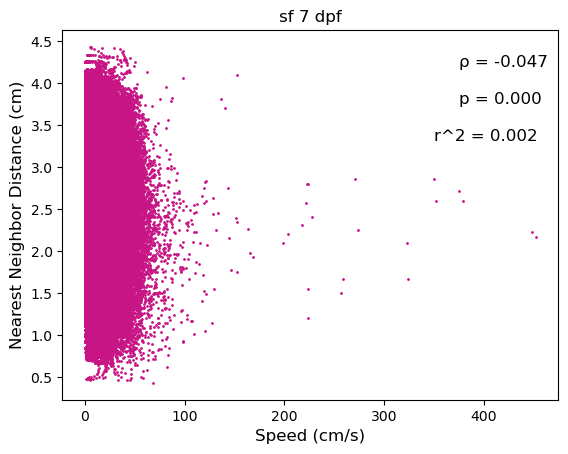

ρ = -0.031
p = 0.000
r^2 = 0.001


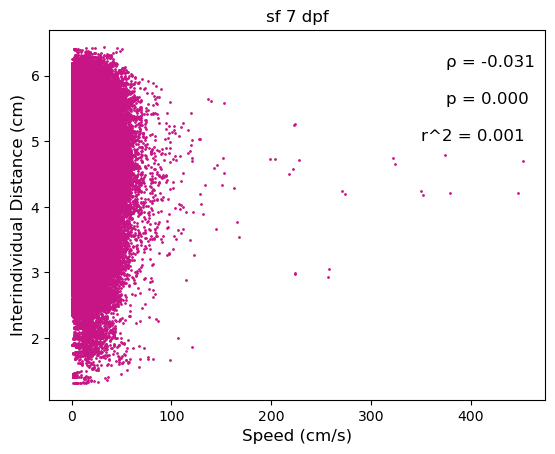

ρ = 0.020
p = 0.000
r^2 = 0.000


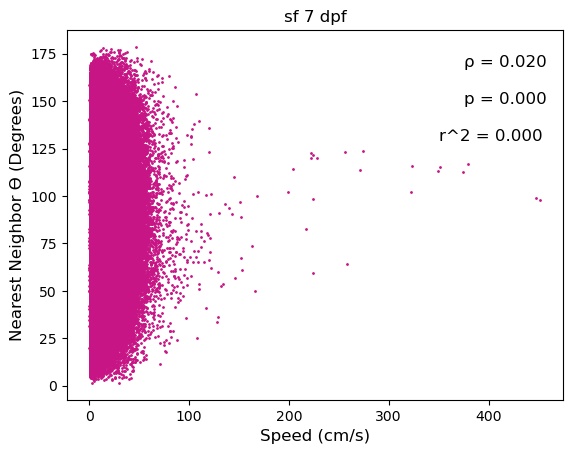

ρ = -0.016
p = 0.000
r^2 = 0.000


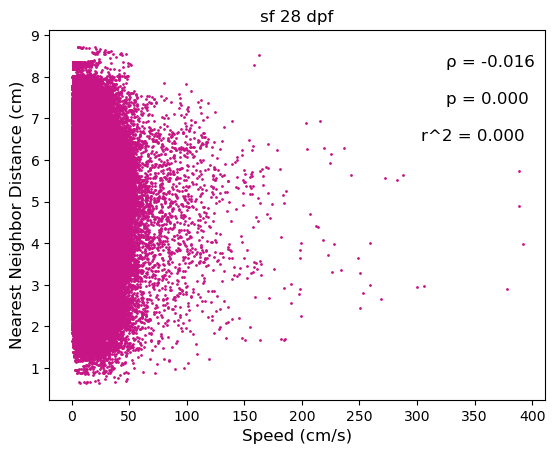

ρ = -0.008
p = 0.000
r^2 = 0.000


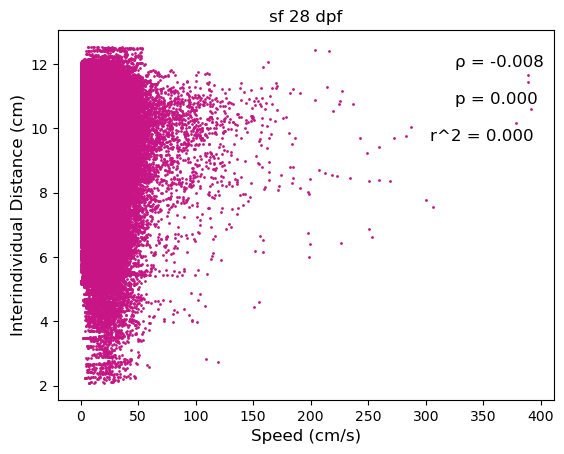

ρ = -0.009
p = 0.000
r^2 = 0.000


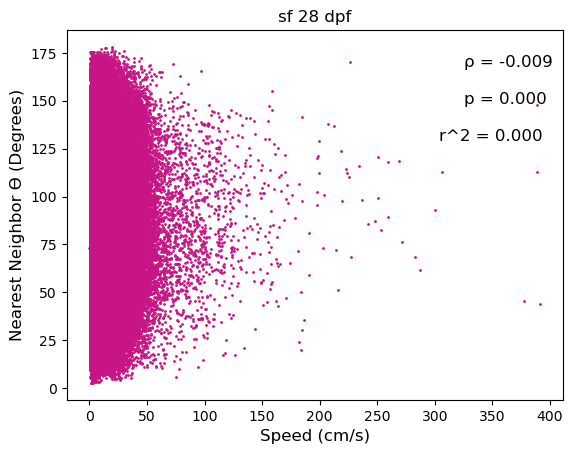

ρ = -0.139
p = 0.000
r^2 = 0.019


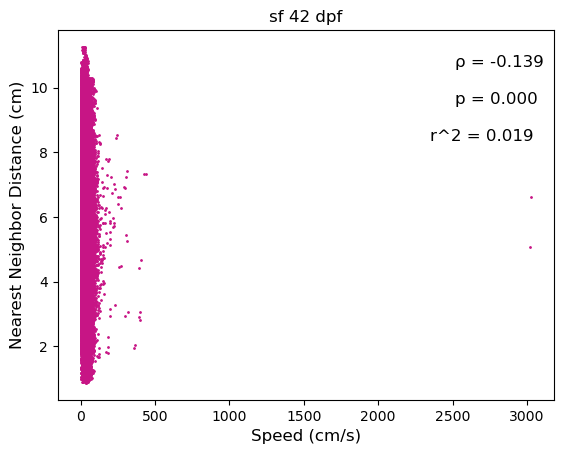

ρ = -0.228
p = 0.000
r^2 = 0.052


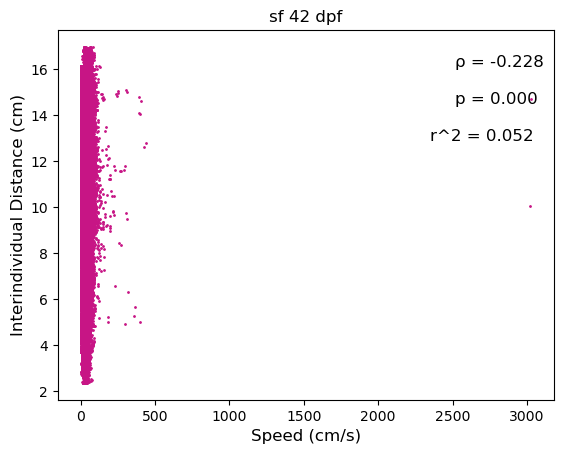

ρ = -0.162
p = 0.000
r^2 = 0.026


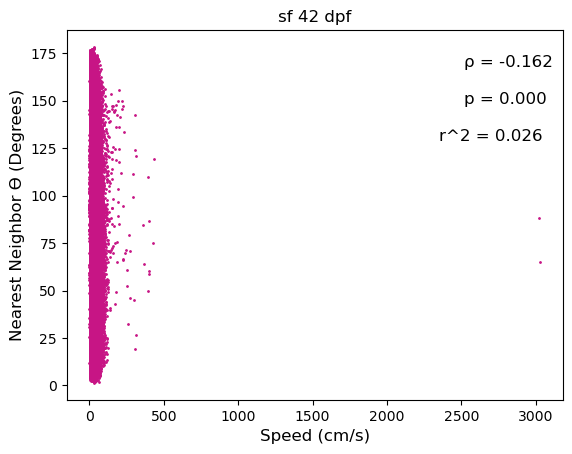

ρ = 0.141
p = 0.000
r^2 = 0.020


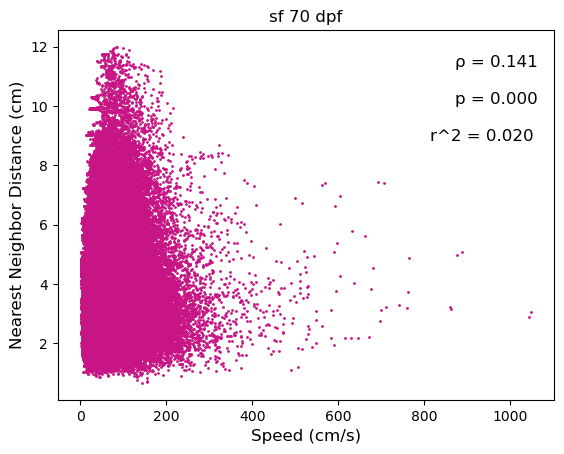

ρ = 0.205
p = 0.000
r^2 = 0.042


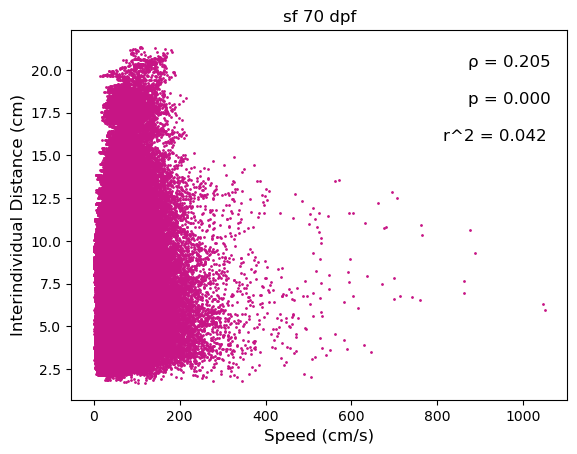

ρ = -0.185
p = 0.000
r^2 = 0.034


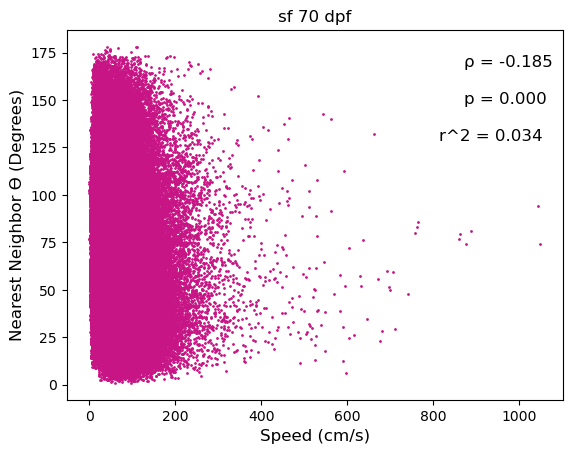

In [13]:
def speed_correlations(dataset, pop):
    speed = np.array([])
    if pop == 'sf': c = 'mediumvioletred'
    elif pop == 'pa': c = 'purple'
        
    for age in dataset.keys():
        data = np.array(dataset[age][0])
#         print(np.shape(data))
        to_compare = {  'nnd' : np.array([]),
                        'iid' : np.array([]),
               'nn_alignment' : np.array([])}
        labels = {'nnd' : 'Nearest Neighbor Distance (cm)', 'iid' : 'Interindividual Distance (cm)',
                 'nn_alignment' : 'Nearest Neighbor \u03F4 (Degrees)'}
        
        speed = data[0,:]
        to_compare['nnd'] = data[1,:]
        to_compare['iid'] = data[2,:]
        to_compare['nn_alignment'] = data[3,:]
            

        for datatype in to_compare.keys():
            correlation, p = stats.spearmanr(speed, to_compare[datatype])
            print(f'\u03C1 = {correlation:.3f}')
            print(f'p = {p:.3f}')
            r2 = np.square(correlation)
            print(f'r^2 = {r2:.3f}')
            plt.scatter(speed, to_compare[datatype], color = c, s = 1)
            plt.title(f'{pop} {age} dpf')
            plt.annotate(f'\u03C1 = {correlation:.3f}', xy=(.8,.9), xycoords="axes fraction", fontsize = 'large')
            plt.annotate(f'p = {p:.3f}', xy=(.8,.8), xycoords="axes fraction", fontsize = 'large')
            plt.annotate(f'r^2 = {r2:.3f}', xy=(.75,.7), xycoords="axes fraction", fontsize = 'large')
            plt.xlabel('Speed (cm/s)', fontsize = 'large')
            plt.ylabel(labels[datatype], fontsize = 'large')
            plt.show()
        
speed_correlations(sf_data, 'sf')
# speed_correlations(pa_data, 'pa')

In [ ]:
def speed_correlations(data):
    speed = np.array([])
    if data == sf_data: c = 'mediumvioletred'
    elif data == pa_data: c = 'purple'
        
    to_compare = {  'nnd' : np.array([]),
                    'iid' : np.array([]),
           'nn_alignment' : np.array([])}
    labels = {'nnd' : 'Nearest Neighbor Distance (cm)', 'iid' : 'Interindividual Distance (cm)',
             'nn_alignment' : 'Nearest Neighbor \u03F4 (Degrees)'}
    for age in data.keys():
        speed = np.concatenate((speed,data[age][:,0]))
        to_compare['nnd'] = np.concatenate((to_compare['nnd'],data[age][:,1]))
        to_compare['iid'] = np.concatenate((to_compare['iid'],data[age][:,2]))
        to_compare['nn_alignment'] = np.concatenate((to_compare['nn_alignment'],data[age][:,3]))

    for datatype in to_compare.keys():
        correlation, p = stats.spearmanr(speed, to_compare[datatype])
        plt.annotate(f'\u03C1 = {correlation:.2f}', xy=(.8,.9), xycoords="axes fraction", fontsize = 'large')
        plt.annotate(f'p = {p:.2f}', xy=(.8,.8), xycoords="axes fraction", fontsize = 'large')
        
        plt.scatter(speed, to_compare[datatype], s = 5, c = c)
        plt.xlabel('Speed (cm/s)', fontsize = 'large')
        plt.ylabel(labels[datatype], fontsize = 'large')
        plt.show()
        
speed_correlations(sf_data)
speed_correlations(pa_data)



In [ ]:
ages = [7, 28, 42, 70]

def graphit(sf_data, pa_data): 
        
    sf_sharp_col = 'mediumvioletred'
    pa_sharp_col = 'purple'

    plt.figure(figsize = (10, 8), dpi = 80)
    
    for age in ages:
        # plot each data point
        plt.scatter(len(sf_data[age][:,0]) * [ages.index(age) + .8], sf_data[age][:,0], marker = '.', c = sf_sharp_col)
        plt.scatter(len(pa_data[age][:,0]) * [ages.index(age) + 1.2], pa_data[age][:,0], marker = '.', c = pa_sharp_col)
        
        #violin plots
        sf = plt.violinplot(sf_data[age][:,0], positions = [ages.index(age) + .8], showextrema=False) 
        sf['bodies'][0].set_zorder(0)lmao t
        sf['bodies'][0].set_edgecolor(sf_sharp_col)
        sf['bodies'][0].set_facecolor(sf_sharp_col)
        pa = plt.violinplot(pa_data[age][:,0], positions = [ages.index(age) + 1.2], showextrema=False) 
        pa['bodies'][0].set_zorder(0)
        pa['bodies'][0].set_edgecolor(pa_sharp_col)
        pa['bodies'][0].set_facecolor(pa_sharp_col)
        
    plt.boxplot ([sf_data[7][:,0],sf_data[28][:,0],sf_data[42][:,0], sf_data[70][:,0]], 
                 positions = np.arange(.8, 4.8, 1), zorder=2, patch_artist = True, showfliers = False, 
                 showbox = False, showcaps = False, whis = 0, showmeans = True, meanline = True,
                 meanprops = dict(color = sf_sharp_col, linestyle = '-', linewidth = 1.2),
                 medianprops = dict(color = sf_sharp_col, linewidth = 1.2, linestyle = '--')) 
    plt.boxplot ([pa_data[7][:,0],pa_data[28][:,0],pa_data[42][:,0], pa_data[70][:,0]], 
                 positions = np.arange(1.2, 5.2, 1), zorder=2, patch_artist = True, showfliers = False, 
                 showbox = False, showcaps = False, whis = 0, showmeans = True, meanline = True,
                 meanprops = dict(color = pa_sharp_col, linestyle = '-', linewidth = 1.2),
                 medianprops = dict(color = pa_sharp_col, linewidth = 1.2, linestyle = '--')) 
        
        
    plt.ylabel('Swimming Speed (cm/s)', fontsize = 'large')   

        
    legend_ele = [Line2D([0], [0], marker = 'o', color = 'white', markerfacecolor = sf_sharp_col, markersize = 10, 
                         label = 'Surface'), Line2D([0], [0], marker = 'o', color = 'white', markerfacecolor = pa_sharp_col, markersize = 10, 
                         label = 'Cave')]# Line2D([0], [0], color = 'darkgray', lw = 2, label = 'Mock')]    
    plt.legend(handles = legend_ele, loc = 'upper left',fontsize = 'large')
    plt.xticks(np.arange(1,5), ages)
    ax = plt.gca()
    plt.xlabel('Age (dpf)', fontsize = 'large')
    plt.show()
    
graphit(sf_data, pa_data)